In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from hcipy import *
from scipy import ndimage
from scipy import fft

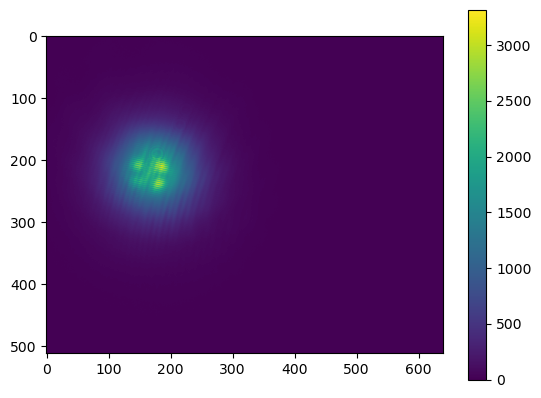

In [2]:
data_dir = "/home/vfndev/yxin/holography/lant2_data_221209/lp21a/"

dark_flist = glob.glob(data_dir+"bkgd/*.fits")
dark_list = []
for file in dark_flist:
    dark_list.append(fits.getdata(file))
dark = np.mean(dark_list,axis=0)

ref_flist = glob.glob(data_dir+"reference/*.fits")
ref_list = []
for file in ref_flist:
    ref_list.append(fits.getdata(file))
ref = np.mean(ref_list,axis=0)-dark

holo_flist = glob.glob(data_dir+"lp21a_fringed/*.fits")
holo_list = []
for file in holo_flist:
    holo_list.append(fits.getdata(file))
holo = np.mean(holo_list,axis=0)-dark

img_flist = glob.glob(data_dir+"lp21a_img/*.fits")
img_list = []
for file in img_flist:
    img_list.append(fits.getdata(file))
img = np.mean(img_list,axis=0)-dark

plt.imshow(holo,vmin=0)
plt.colorbar()

(329, 329)
2494.0222308731472


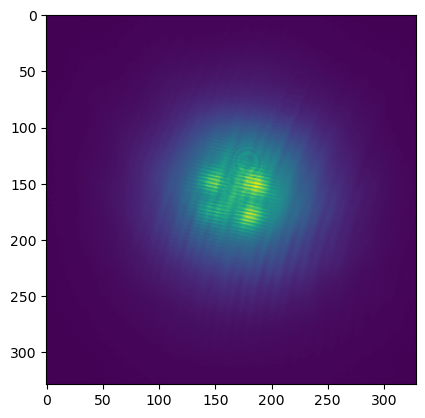

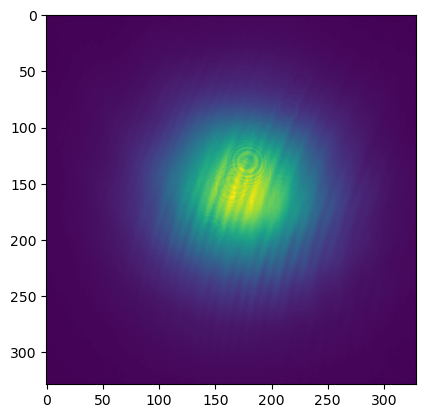

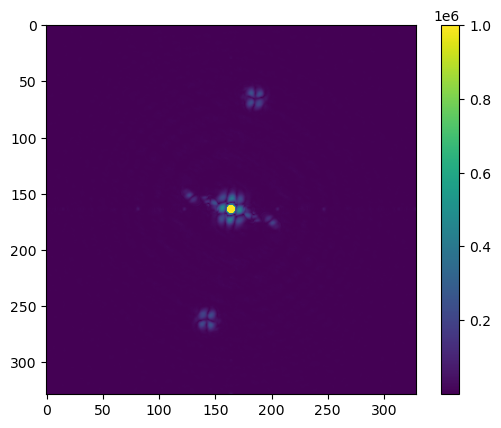

In [3]:
centerx = 225
centery = 165
crop_width = 329

holo_crop = holo[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]
ref_crop = ref[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]
img_crop = img[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]

print(holo_crop.shape)

plt.figure()
plt.imshow(holo_crop)

plt.figure()
plt.imshow(ref_crop)

fft_holo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(holo_crop)))

print(np.median(np.abs(fft_holo)))

plt.figure()
plt.imshow(np.abs(fft_holo),vmax=1e6)
plt.colorbar()


(329, 329)


/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/hcipy/plotting/field.py:405: RuntimeWarning: invalid value encountered in remainder
  hsv[..., 0] = np.angle(field) / (2 * np.pi) % 1


Text(0.5, 1.0, 'Phase')

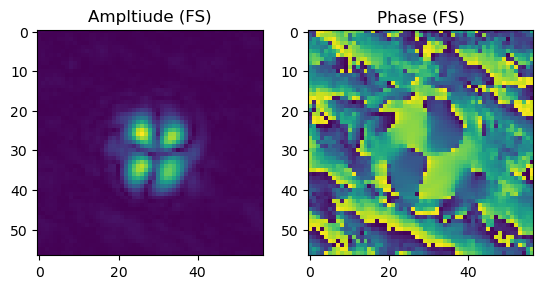

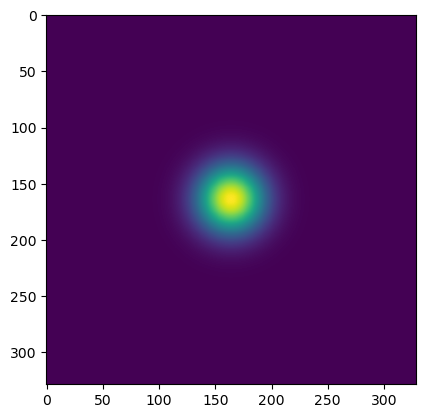

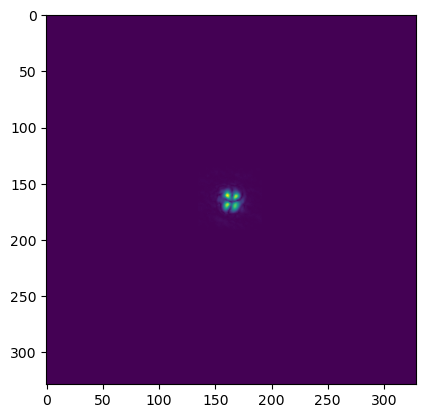

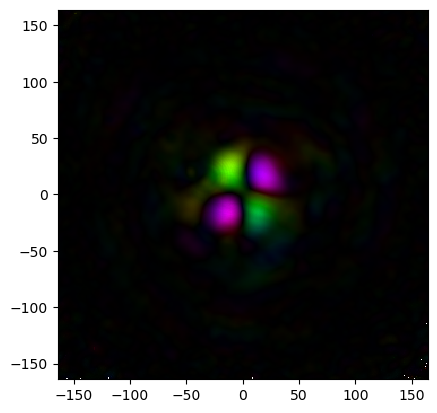

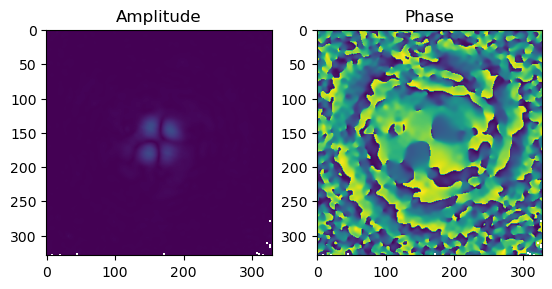

In [4]:
#off-axis lobe crope
x1 = 63.5
y1 = 185
box_width = 57

fftgram_filt = np.zeros(fft_holo.shape,dtype='complex128')
print(fftgram_filt.shape)

fftgram_crop = fft_holo[int(x1-box_width/2):int(x1+box_width/2),int(y1-box_width/2):int(y1+box_width/2)]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(fftgram_crop))
plt.title("Ampltiude (FS)")
plt.subplot(1,2,2)
plt.imshow(np.angle(fftgram_crop))
plt.title("Phase (FS)")

xmid = int(fftgram_filt.shape[0]/2)
ymid = int(fftgram_filt.shape[1]/2)
fftgram_filt[int(xmid-box_width/2):int(xmid+box_width/2),int(ymid-box_width/2):int(ymid+box_width/2)] = fftgram_crop

filter_ft = np.zeros(fft_holo.shape)
filter_ft[xmid,ymid]=1

plt.figure()
plt.imshow(ndimage.gaussian_filter(filter_ft, 21))

fftgram_filt = ndimage.gaussian_filter(filter_ft, 21)*fftgram_filt

plt.figure()
plt.imshow(np.abs(fftgram_filt))

recon_map = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fftgram_filt)))/np.sqrt(ref_crop)

grid = make_uniform_grid([recon_map.shape[0],recon_map.shape[1]], [recon_map.shape[0],recon_map.shape[1]])

recon_map_field = Field(np.transpose(recon_map).ravel(),grid)

plt.figure()
imshow_field(recon_map_field)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.rot90(np.abs(recon_map),k=1,axes=(0,1)),vmax=7e-3)
plt.title("Amplitude")
plt.subplot(1,2,2)
plt.imshow(np.rot90(np.angle(recon_map),k=1,axes=(0,1)))
plt.title("Phase")

In [5]:
#decompose into LP modes
radii = np.linspace(10,50,21)
coeffs = np.zeros((len(radii),6))
for m in range(len(radii)):
    lp_modes = make_lp_modes(grid, 5, radii[m])
    for n in range(len(lp_modes)):
        coeffs[m,n] = np.abs(np.nansum(np.conj(lp_modes[n])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[n])*lp_modes[n],axis=None))
             

30.0


Text(0.5, 1.0, 'Coefficients of Mode from LP21a Port')

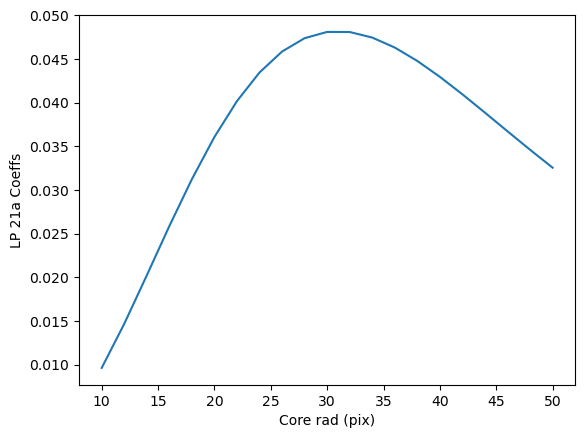

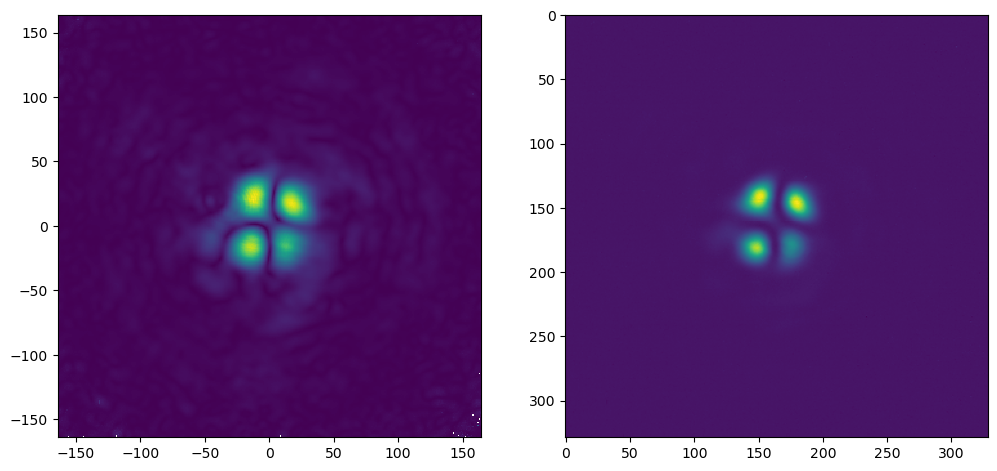

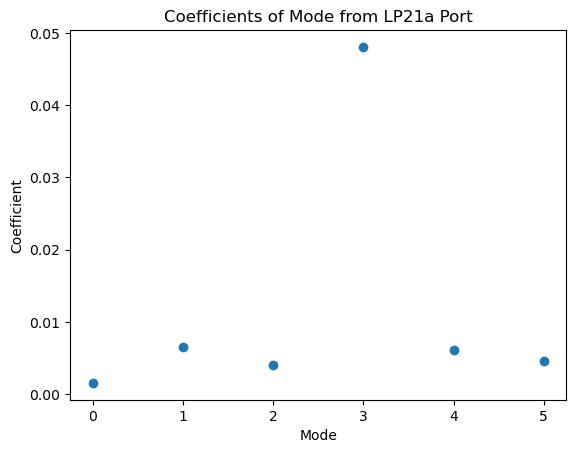

In [7]:
plt.figure()
plt.plot(radii,coeffs[:,3])
plt.xlabel('Core rad (pix)')
plt.ylabel('LP 21a Coeffs')

best_r_idx = np.argmax(coeffs[:,3])
best_r = radii[best_r_idx]
print(best_r)

lp_modes = make_lp_modes(grid, 5, best_r)

plt.figure(figsize=[12,10])
plt.subplot(1,2,1)
imshow_field(np.abs(recon_map_field)/np.nanmax(np.abs(recon_map_field)))
plt.subplot(1,2,2)
plt.imshow(np.rot90(img_crop))

smf_coeffs = coeffs[best_r_idx,:]
plt.figure()
plt.scatter(range(len(lp_modes)),smf_coeffs)
plt.xlabel('Mode')
plt.ylabel('Coefficient')
plt.title('Coefficients of Mode from LP21a Port')

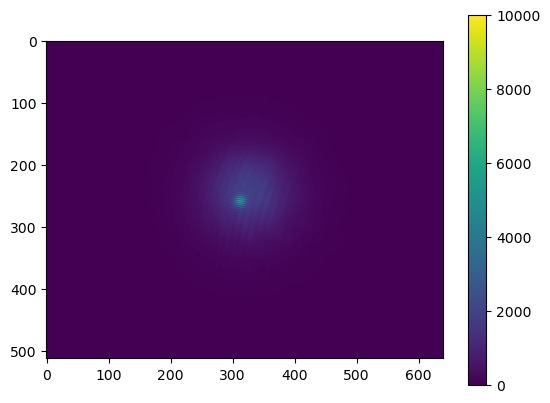

In [85]:
data_dir = "/home/vfndev/yxin/holography/smf_data_221209/"

dark_flist = glob.glob(data_dir+"bkgd/*.fits")
dark_list = []
for file in dark_flist:
    dark_list.append(fits.getdata(file))
dark = np.mean(dark_list,axis=0)

ref_flist = glob.glob(data_dir+"reference/*.fits")
ref_list = []
for file in ref_flist:
    ref_list.append(fits.getdata(file))
ref = np.mean(ref_list,axis=0)-dark

holo_flist = glob.glob(data_dir+"smf_fringed/*.fits")
holo_list = []
for file in holo_flist:
    holo_list.append(fits.getdata(file))
holo = np.mean(holo_list,axis=0)-dark

plt.imshow(holo,vmin=0,vmax=10000)
plt.colorbar()

(505, 505)
2592.8538150565937


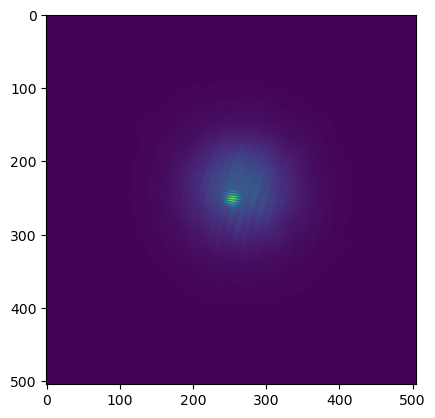

<Figure size 640x480 with 0 Axes>

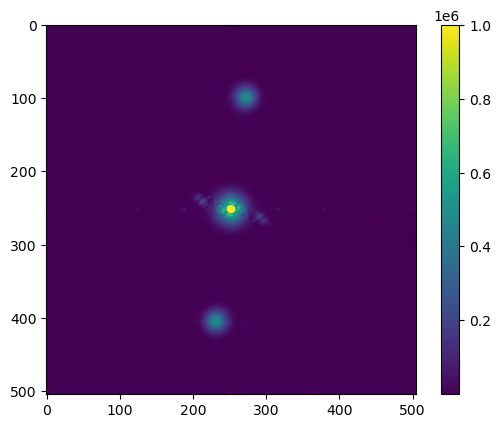

In [86]:
centerx = 260
centery = 312
crop_width = 505

holo_crop = holo[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]
ref_crop = ref[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]

pad_num = 0
holo_crop = np.pad(holo_crop,((pad_num,pad_num),(pad_num,pad_num)))
ref_crop = np.pad(ref_crop,((pad_num,pad_num),(pad_num,pad_num)))

print(holo_crop.shape)

#filter_img = np.zeros(holo_crop.shape)
#xmid_img = int(filter_img.shape[0]/2)
#ymid_img = int(filter_img.shape[1]/2)
#filter_img[xmid_img,ymid_img]=1

#holo_crop = ndimage.gaussian_filter(filter_img, 101)*holo_crop

plt.figure()
plt.imshow(holo_crop)

fft_holo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(holo_crop)))
fft_ref = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ref_crop)))

plt.figure()

print(np.median(np.abs(fft_holo)))

plt.figure()
plt.imshow(np.abs(fft_holo),vmax=1e6)
plt.colorbar()


(505, 505)
252
252


/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/hcipy/plotting/field.py:405: RuntimeWarning: invalid value encountered in remainder
  hsv[..., 0] = np.angle(field) / (2 * np.pi) % 1


Text(0.5, 1.0, 'Phase')

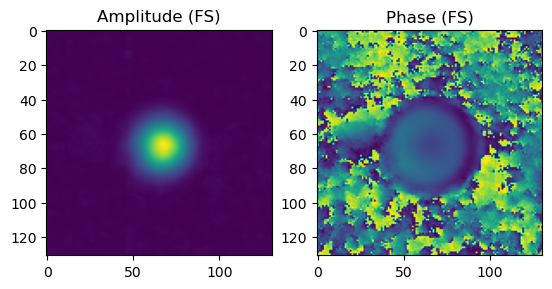

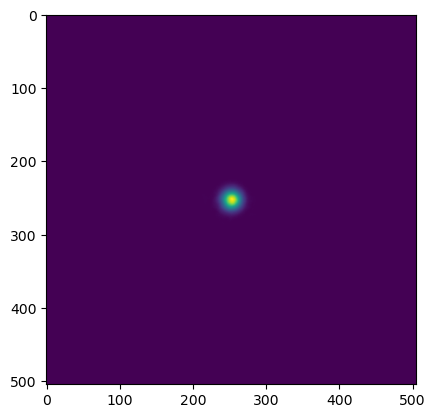

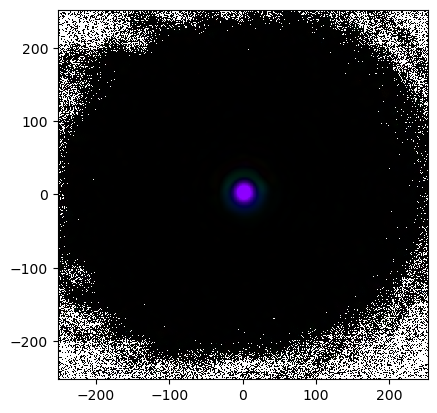

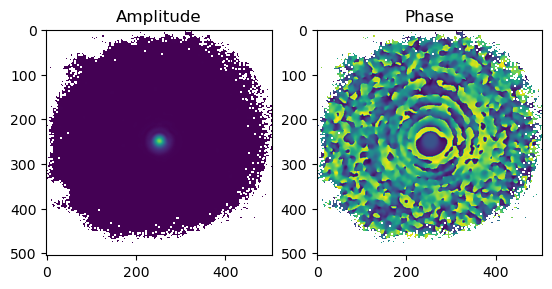

In [87]:
#off-axis lobe crope
x1 = 98
y1 = 271
box_width = 131

fftgram_filt = np.zeros(fft_holo.shape,dtype='complex128')
print(fftgram_filt.shape)

fftgram_crop = fft_holo[int(x1-box_width/2):int(x1+box_width/2),int(y1-box_width/2):int(y1+box_width/2)]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(fftgram_crop))
plt.title('Amplitude (FS)')
plt.subplot(1,2,2)
plt.imshow(np.angle(fftgram_crop))
plt.title('Phase (FS)')

xmid = int(fftgram_filt.shape[0]/2)
ymid = int(fftgram_filt.shape[1]/2)

print(xmid)
print(ymid)
fftgram_filt[int(xmid-box_width/2):int(xmid+box_width/2),int(ymid-box_width/2):int(ymid+box_width/2)] = fftgram_crop

filter_ft = np.zeros(fft_holo.shape)
filter_ft[xmid,ymid]=1

fftgram_filt = ndimage.gaussian_filter(filter_ft, 21)*fftgram_filt

plt.figure()
plt.imshow(np.abs(fftgram_filt))

recon_map = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fftgram_filt)))/np.sqrt(ref_crop)

grid = make_uniform_grid([recon_map.shape[0],recon_map.shape[1]], [recon_map.shape[0],recon_map.shape[1]])

recon_map_field = Field(np.transpose(recon_map).ravel(),grid)

plt.figure()
imshow_field(recon_map_field,vmax=5e-3)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.rot90(np.abs(recon_map),k=1,axes=(0,1)),vmax=1e-2)
plt.title("Amplitude")
plt.subplot(1,2,2)
plt.imshow(np.rot90(np.angle(recon_map),k=1,axes=(0,1)))
plt.title("Phase")


In [61]:
#decompose into LP modes
radii = np.linspace(5,30,21)
coeffs = np.zeros((len(radii),6))
for m in range(len(radii)):
    lp_modes = make_lp_modes(grid, 5, radii[m])
    for n in range(len(lp_modes)):
        coeffs[m,n] = np.abs(np.nansum(np.conj(lp_modes[n])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[n])*lp_modes[n],axis=None))
               

/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


16.25


/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/hcipy/plotting/field.py:405: RuntimeWarning: invalid value encountered in remainder
  hsv[..., 0] = np.angle(field) / (2 * np.pi) % 1


Text(0.5, 1.0, 'Coefficients of Mode from SMF')

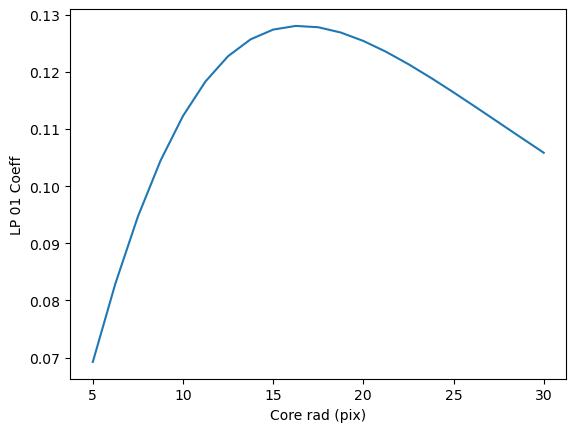

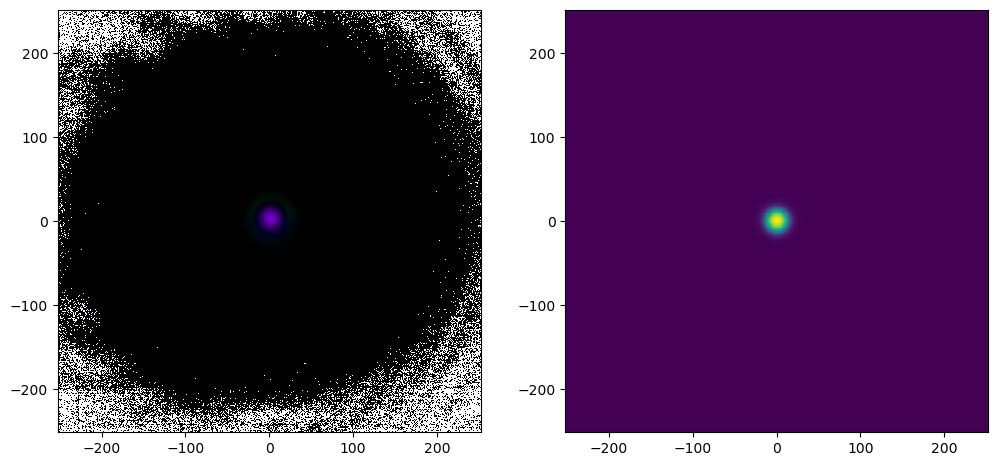

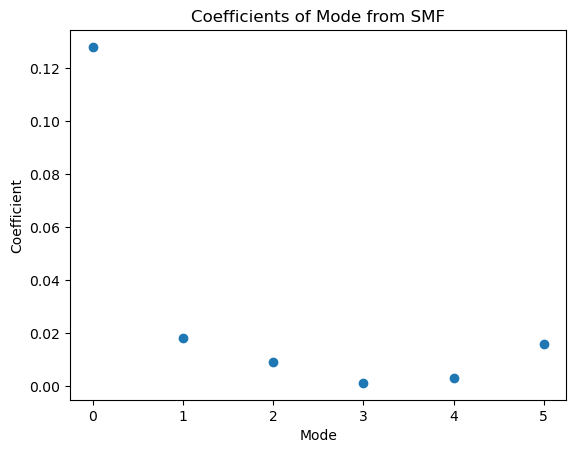

In [90]:
plt.figure()
plt.plot(radii,coeffs[:,0])
plt.xlabel('Core rad (pix)')
plt.ylabel('LP 01 Coeff')

best_r_idx = np.argmax(coeffs[:,0])
best_r = radii[best_r_idx]
print(best_r)

lp_modes = make_lp_modes(grid, 5, best_r)

plt.figure(figsize=[12,10])
plt.subplot(1,2,1)
imshow_field(recon_map_field,vmax=1e-2)
plt.subplot(1,2,2)
imshow_field(lp_modes[0])

smf_coeffs = coeffs[best_r_idx,:]
plt.figure()
plt.scatter(range(len(lp_modes)),smf_coeffs)
plt.xlabel('Mode')
plt.ylabel('Coefficient')
plt.title('Coefficients of Mode from SMF')